In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..")

from src.data_processing import load_processed_train_csv
from src.models import (
    LogisticRegressionNumpy,
    cross_validate_logreg_numpy,
    sklearn_logreg_train_eval,
    confusion_matrix,
    accuracy_score,
    precision_recall_f1
)
from src.visualization import plot_confusion_matrix, plot_roc_curve

Đọc dữ liệu train đã xử lý

In [4]:
X, y = load_processed_train_csv("../data/processed/processed_train.csv")
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (19158, 12)
y shape: (19158,)


### Features Engineering

Các feature gốc trong processed_train.csv:
- city_dev_z
- training_hours_z
- experience_z
- company_size_z
- last_new_job_z
- city_code
- gender_code
- rel_exp_code
- enrolled_uni_code
- edu_level_code
- major_disc_code
- company_type_code

Ta sẽ tạo thêm một vài đặc trưng:
1. `exp_training_interaction = experience_z * training_hours_z`
2. `high_city_dev` = 1 nếu city_dev_z thuộc top 25% lớn nhất, ngược lại 0.

Sau đó ghép vào X để huấn luyện.

In [5]:
# 1. Tương tác giữa kinh nghiệm & training_hours
city_dev_z = X[:, 0]
training_z = X[:, 1]
exp_z = X[:, 2]
company_size_z = X[:, 3]

exp_training_interaction = exp_z * training_z

# 2. Biến nhị phân cho thành phố phát triển cao
threshold_city = np.quantile(city_dev_z, 0.75)
high_city_dev = (city_dev_z >= threshold_city).astype(float)

# Ghép thành X_fe
X_fe = np.column_stack([X, exp_training_interaction, high_city_dev])
print("X_fe shape (sau khi thêm feature):", X_fe.shape)

X_fe shape (sau khi thêm feature): (19158, 14)


In [6]:
# Chia train/validation 80/20
n = len(y)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

split = int(0.8 * n)
train_idx = idx[:split]
val_idx = idx[split:]

X_train, X_val = X_fe[train_idx], X_fe[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

Train: (15326, 14) (15326,)
Val: (3832, 14) (3832,)


## Logistic Regression NumPy + K-Fold Cross Validation

In [10]:
# K-fold cross validate trên toàn bộ tập X_fe, y
cv_result = cross_validate_logreg_numpy(
    X_fe, y,
    k=5,
    lr=0.1,
    n_iters=1000
)
print("K-fold CV (NumPy Logistic Regression với feature engineering):")
for k, v in cv_result.items():
    print(f"{k}: {v:.4f}")

K-fold CV (NumPy Logistic Regression với feature engineering):
accuracy: 0.6668
precision: 0.4309
recall: 0.3408
f1: 0.2669


## Huấn luyện Logistic Regression (NumPy) trên tập train / đánh giá trên validation

=== NumPy Logistic Regression ===
Accuracy: 0.7455636743215032
Precision: 0.46355685131181823
Recall: 0.16736842105261396
F1: 0.24593967513499507


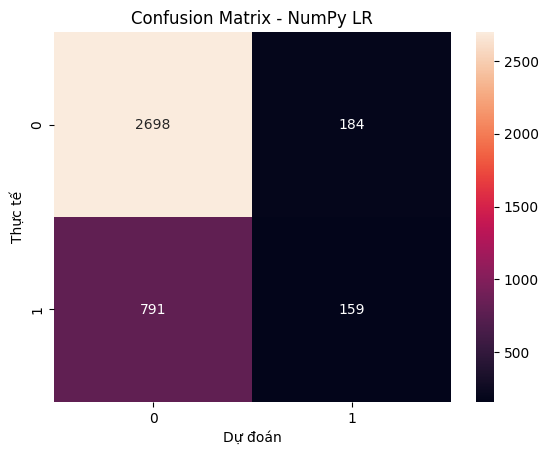

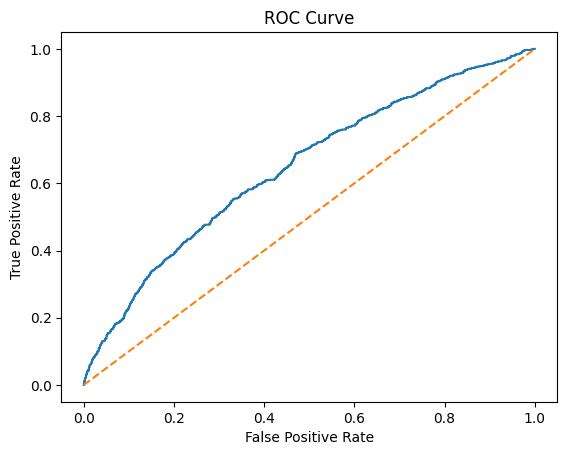

In [8]:
lr_np = LogisticRegressionNumpy(lr=0.1, n_iters=1000, verbose=False)
lr_np.fit(X_train, y_train)

y_pred_np = lr_np.predict(X_val)
y_proba_np = lr_np.predict_proba(X_val)

acc_np = accuracy_score(y_val, y_pred_np)
p_np, r_np, f1_np = precision_recall_f1(y_val, y_pred_np)

print("=== NumPy Logistic Regression ===")
print("Accuracy:", acc_np)
print("Precision:", p_np)
print("Recall:", r_np)
print("F1:", f1_np)

cm_np = confusion_matrix(y_val, y_pred_np)
plot_confusion_matrix(cm_np, labels=("0", "1"), title="Confusion Matrix - NumPy LR")
plt.show()

plot_roc_curve(y_val, y_proba_np)
plt.show()

In [9]:
print("Số feature (bao gồm feature engineering):", X_fe.shape[1])
print("Trọng số W (NumPy LR):")
print(lr_np.W.ravel())

Số feature (bao gồm feature engineering): 14
Trọng số W (NumPy LR):
[-7.01959571 -0.32126991 -1.44538252 -0.54249471  0.03682324 -0.3335584
  0.12385847  0.96131355 -1.28423004 -1.47315349 -0.96476464  2.26465201
 -0.09814717  0.07413237]
